In [1]:
from sortedcontainers import SortedList
from math import log, exp, sqrt
from random import random, randrange
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from time import time

In [2]:
# NOTE 1 << i = 2^i

# q[i] = p[2^i - 1]
def build_envelope(sl, q, eta):
    logK = len(q)
    for i in range(logK):
        q[i] = exp(-eta*sl[(1 << i)-1][0])  

# returns an arm using rejection sampling
# example to keep in mind:
# \tilde{p} = (8, 7, 6, 5, 4, 3, 2, 1)
# \tilde{q} = (8, 8, 7, 7, 5, 5, 5, 5)
# bucket    = (0____ 1____ 2_________)
# q         = (8,    7,    5) 


# Samples from exp(-eta*L) using the proposal q. Returns (L[arm], arm) pair
def sample(q, sl, eta):
    logK = len(q)
    
    # Compute normalizing constant of q
    Z = 2.0*q[0]
    for i in range(1, logK):
        Z += q[i]*(1 << i)
        
    # Rejection while loop
    counter = 0
    while True:
        counter += 1
        # First we draw a random bucket
        u = random()
        bucket = -1
        cdf = 2*q[0]
        if u < cdf/Z:
            bucket = 0
        if bucket < 0:
            for i in range(1, logK):
                cdf += q[i]*(1 << i)
                if u < cdf/Z:
                    bucket = i
                    break
        if bucket < 0:
            print("Error: bucket not assigned")
            return 

        # We draw the arm uniformly within the bucket. Draw = k means we drew the k-th largest arm
        if bucket == 0:
            draw = randrange(2)
        else:
            draw = (1 << bucket) + randrange(1 << bucket)
            
        # Rejection step
        if random() < exp(-eta*sl[draw][0])/q[bucket]:
#             print(counter)
            return sl[draw]
        
        
# Returns (x,q(x)) where x is a sample from q and q(x) is the (normalized) density of point x
def sample_envelope(q):
    logK = len(q)
    
    # Compute normalizing constant of q
    Z = 2.0*q[0]
    for i in range(1, logK):
        Z += q[i]*(1 << i)
        
    # First we draw a random bucket
    u = random()
    bucket = -1
    cdf = 2*q[0]
    if u < cdf/Z:
        bucket = 0
    if bucket < 0:
        for i in range(1, logK):
            cdf += q[i]*(1 << i)
            if u < cdf/Z:
                bucket = i
                break
    if bucket < 0:
        print("Error: bucket not assigned")
        return 

    # We draw the arm uniformly within the bucket. Draw = k means we drew the k-th largest arm
    if bucket == 0:
        draw = randrange(2)
    else:
        draw = (1 << bucket) + randrange(1 << bucket)
    return draw, q[bucket]/Z

In [4]:
# Performs one step of the modified EXP3 algorithm and returns loss incurred
def mod_EXP3(sl, q, eta, losstype, frac=None, mult=None, t=None, T=None):
    logK = len(q)
    
    # BUILDING ENVELOPE
    build_envelope(sl, q, eta)
    
    # SAMPLING ARM
    L, arm = sample(q, sl, eta)
    
    # OBSERVING LOSS
    if losstype == 'cliff':
        loss = cliff_loss(arm, logK, frac)
    elif losstype == 'changing-cliff':
        loss = changing_loss(arm, logK, mult, t, T)
    elif losstype == 'stochastic':
        loss = stochastic(arm, logK)
    else:
        print("Loss missspecified")
    
    # J is not the true index, but indexed according to the sorted order
    J, q_prob = sample_envelope(q)
    dL = loss*exp(-eta*sl[J][0])/(exp(-eta*L)*q_prob)
    
    # UPDATING SORTED ARRAY
    sl.remove((L, arm))
    sl.add((L+dL, arm))
    return loss

# Performs one step of EXP3 and return (l,s) where l is the loss incurred and s = sum(L)
def EXP3(L, p, s, eta, logK, losstype, frac=None, mult=None, t=None, T=None):
    arm = np.random.choice(range(1 << logK), 1, p = p)[0]
    if losstype == 'cliff':
        loss = cliff_loss(arm, logK, frac)
    elif losstype == 'changing-cliff':
        loss = changing_loss(arm, logK, mult, t, T)
    elif losstype == 'stochastic':
        loss = stochastic(arm, logK)
    else:
        print("Loss missspecified")
    
    s -= exp(-eta*L[arm])
    L[arm] += loss/p[arm]
    s += exp(-eta*L[arm])
    for i in range(1 << logK):
        p[i] = exp(-eta*L[i])/s
    return loss, s

In [5]:
# Best arm is always 0
def cliff_loss(arm, logK, frac):
    return 0 if arm < (1 << logK)*frac else 1

# Best arm is 1/mult on average
def changing_loss(arm, logK, mult, t, T):
    bucket = int(t*mult/float(T))
    if bucket*(1 << logK)/float(mult) <= arm <= (bucket + 1)*(1 << logK)/float(mult):
        return 0
    else: return 1

# Best arm is always 0
def stochastic(arm, logK):
#     return random()
    return min(1,max(0,arm/float(1<<logK) - 0.3*random()))

In [6]:
# Setting up the self balancing binary search tree
sl = SortedList()

# Comparing iteration speed

In [14]:
T = 10000
losses = ["cliff", "changing-cliff", "stochastic"]
# Parameters of the losstypes
frac = 0.1
mult = 5
losstype = losses[2]

logKs = range(2,26)
times = np.zeros((len(logKs), 2))

In [16]:
# Theoretical stepsize for EXP3 on this time horizon, same eta used for both algorithms
eta = sqrt(2*logK/float(T*(1 << logK)))

# Running mod_EXP3
for j in range(len(logKs)):
    print(str(int(100*float(j+1)/len(logKs)))+"%")
    logK = logKs[j]
    
    # Clearing the datastructure
    sl.clear()
    sl.update([(0,i) for i in range(1 << logK)])
    q = [None]*logK
    
    start = time()
    for t in range(T):
        _ = mod_EXP3(sl, q, eta, losstype, frac=frac,  mult=mult, t=t, T=T)
    times[j,0] = time()-start
    
# Running EXP3, note we decrease T and extrapolate because otherwise takes forever
T = 100
for j in range(len(logKs)):
    print(str(int(100*float(j+1)/len(logKs)))+"%")
    logK = logKs[j]
    
    if logK > 20:
        times[j, 1] = np.NaN
        continue
    # Setup for EXP3
    L = [0.0]*(1 << logK)
    p = [1/float(1 << logK)]*(1 << logK)
    s = float(1 << logK) 
                 
    start = time()
    for t in range(T):
        _, s = EXP3(L, p, s, eta, logK, losstype, frac=frac,  mult=mult, t=t, T=T)
    times[j,1] = 100*(time()-start)

4%
8%
12%
16%
20%
25%
29%
33%
37%
41%
45%
50%
54%
58%
62%
66%
70%
75%
79%
83%
87%
91%
95%
100%
4%
8%
12%
16%
20%
25%
29%
33%
37%
41%
45%
50%
54%
58%
62%
66%
70%
75%
79%
83%
87%
91%
95%
100%


(0.0, 10.0)

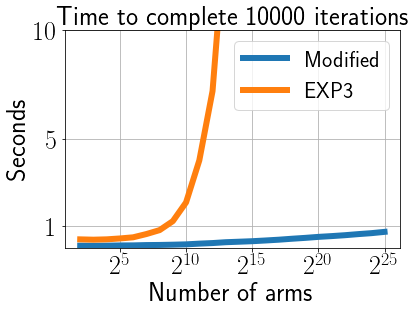

In [17]:
matplotlib.rcParams['text.usetex'] = True
plt.plot(logKs, times, linewidth=6)
plt.title("Time to complete {} iterations".format(T*100), size=26)
plt.legend(['Modified', 'EXP3'], fontsize=22)
plt.xlabel("Number of arms", size=26)
plt.ylabel('Seconds', size=26)
plt.yticks(ticks=[1,5, 10], size=26)
plt.xticks(ticks=[5, 10, 15, 20, 25], labels=[r"$2^5$", r"$2^{10}$", r"$2^{15}$", r"$2^{20}$", r"$2^{25}$"], size=26)
plt.grid(b=True)
plt.ylim(0,10)

# Comparing regret

In [18]:
logK = 8
T = 100000
frac = 0.1
mult=5
losstype = 'changing-cliff'

In [19]:
# Setup for modified EXP3
sl.clear()
sl.update([(0,i) for i in range(1 << logK)])
q = [None]*logK

# Setup for EXP3
L = [0.0]*(1 << logK)
p = [1/float(1 << logK)]*(1 << logK)
s = float(1 << logK)

times = np.zeros((T,2))
regret = np.zeros((T, 2))

eta = sqrt(2*logK/float(T*(1 << logK)))
for t in range(T):
    start = time()
    tmp = mod_EXP3(sl, q, eta, losstype, frac=frac,  mult=mult, t=t, T=T)
    regret[t,0] = tmp + (0 if t==0 else regret[t-1,0])
    times[t,0] = time()-start + (0 if t==0 else times[t-1,0])

    if t%1000 == 0: s=np.sum([exp(-eta*LL) for LL in L])
    start = time()
    regret[t,1], s = EXP3(L, p, s, eta, logK, losstype, frac=frac,  mult=mult, t=t, T=T)
    regret[t,1] += (0 if t==0 else regret[t-1,1])
    times[t,1] = time() - start + (0 if t==0 else times[t-1,1])

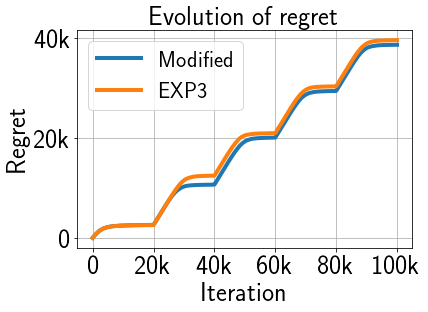

In [24]:
matplotlib.rcParams['text.usetex'] = True
plt.plot(regret, linewidth=4)
plt.title("Evolution of regret", size=26)
plt.legend(['Modified', 'EXP3'], fontsize=22)
plt.xlabel("Iteration", size=26)
plt.ylabel('Regret', size=26)
plt.yticks(ticks=[0,20000,40000], labels=["0", "20k", "40k"], size=26)
plt.xticks(ticks=[0,20000,40000,60000, 80000,100000], labels=["0", "20k", "40k", "60k", "80k", "100k"], size=26)
plt.grid(b=True)
# plt.ylim(0,10)
plt.show()

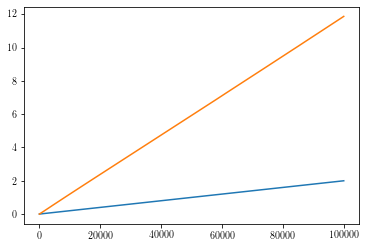

In [25]:
plt.plot(times)